In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from summarytools import dfSummary
from sklearn.preprocessing import OneHotEncoder,StandardScaler,OrdinalEncoder
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split,StratifiedKFold,cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import log_loss, accuracy_score,roc_auc_score,f1_score, precision_recall_curve, auc, average_precision_score,PrecisionRecallDisplay,RocCurveDisplay,ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier,HistGradientBoostingClassifier
from xgboost import XGBClassifier
import shap
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK,space_eval
from hyperopt.pyll import scope
from scipy.stats import uniform 
from scipy.stats import randint 
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import mlflow
from lightgbm import LGBMClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import time

### Preprocessing Strategy I: 
1. Remove correlated features ('REGION_RATING_CLIENT_W_CITY' correlates with 'REGION_RATING_CLIENT'), ID column, low variance column ('FLAG_MOBIL' is 100% 1), and columns with over 50% missing<br>
2. Feature engineer using address discrepancies and document count
3. Fix incorrect values ('DAYS_EMPLOYED')
4. Leave numeric columns, binary columns as is, encode categorical columns with OrdinalEncoder <br>
5. This strategy works with XGBoost, LightGBM, HistGradientBoostingClassifier as they all can deal with missing values. And as tree-based models, there is no need to scale the input. 

In [5]:
df=pd.read_csv("data/application_data.csv")

# feature engineering on address discrepancies and document count
df['document']= df['FLAG_DOCUMENT_2']+df['FLAG_DOCUMENT_3']+df['FLAG_DOCUMENT_4']+df['FLAG_DOCUMENT_5']+df['FLAG_DOCUMENT_6']\
           +df['FLAG_DOCUMENT_7']+df['FLAG_DOCUMENT_8']+df['FLAG_DOCUMENT_9']+df['FLAG_DOCUMENT_10']+df['FLAG_DOCUMENT_11']\
           +df['FLAG_DOCUMENT_12']+df['FLAG_DOCUMENT_13']+df['FLAG_DOCUMENT_14']+df['FLAG_DOCUMENT_15']+df['FLAG_DOCUMENT_16']\
           +df['FLAG_DOCUMENT_17']+df['FLAG_DOCUMENT_18']+df['FLAG_DOCUMENT_19']+df['FLAG_DOCUMENT_20']+df['FLAG_DOCUMENT_21']

df['address'] = df['REG_REGION_NOT_LIVE_REGION']+df['REG_REGION_NOT_WORK_REGION']+df['LIVE_REGION_NOT_WORK_REGION']\
            +df['REG_CITY_NOT_LIVE_CITY']+df['REG_CITY_NOT_WORK_CITY']+df['LIVE_CITY_NOT_WORK_CITY']

# drop the above and the ID column, FLAG_MOBIL is 100% 1, REGION_RATING_CLIENT_W_CITY correlates with REGION_RATING_CLIENT
drop_col = ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_3','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7',
           'FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13',
           'FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16','FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19',
           'FLAG_DOCUMENT_20','FLAG_DOCUMENT_21','REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION',
           'LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY',
           'SK_ID_CURR','FLAG_MOBIL','REGION_RATING_CLIENT_W_CITY']

df.drop(columns=drop_col,inplace=True)

# drop columns with over 50% missing
drop_col = ['OWN_CAR_AGE','EXT_SOURCE_1','APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG','YEARS_BUILD_AVG',
            'COMMONAREA_AVG', 'ELEVATORS_AVG','ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
            'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG','NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 
            'BASEMENTAREA_MODE','YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE','ELEVATORS_MODE', 
            'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE','LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
            'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI','BASEMENTAREA_MEDI', 
            'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI','COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI',
            'FLOORSMAX_MEDI','FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI','LIVINGAREA_MEDI', 
            'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI','FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE',
            'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']

#df['missing_count'] = df[drop_col].isna().sum(axis=1)
df.drop(columns=drop_col,inplace=True)

# preprocessing outside of pipeline
#df['DAYS_LAST_PHONE_CHANGE']=df['DAYS_LAST_PHONE_CHANGE'].fillna(1)
#df['CNT_FAM_MEMBERS'] = df['CNT_FAM_MEMBERS'].fillna(df['CNT_CHILDREN']+1)
#df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].fillna("Others")
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace({365243:0})
#df['NAME_TYPE_SUITE'] = df['NAME_TYPE_SUITE'].fillna("Missing")

df.shape

(307511, 46)

In [6]:
num_features1 = ['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','REGION_POPULATION_RELATIVE',
                'DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','CNT_FAM_MEMBERS','REGION_RATING_CLIENT',
                'EXT_SOURCE_2','DAYS_LAST_PHONE_CHANGE','OBS_30_CNT_SOCIAL_CIRCLE',
                'DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE',
                'document','address'] # no missing indicator
num_features2 = ['EXT_SOURCE_3','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK',
                 'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR'] # add missing indicator
cat_features = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE','NAME_INCOME_TYPE',
                'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','WEEKDAY_APPR_PROCESS_START',
                'HOUR_APPR_PROCESS_START','ORGANIZATION_TYPE']
# binary_features = ['FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL',
#                    'REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION',
#                    'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY','FLAG_DOCUMENT_2', 
#                    'FLAG_DOCUMENT_3','FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6','FLAG_DOCUMENT_7',
#                    'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9','FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
#                    'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15','FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
#                    'FLAG_DOCUMENT_18','FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']
binary_features = ['FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL']

In [7]:
# for tree based model, no need to scale numerical variable and use ordinal encoder for categorical variable
numeric_transformer1 = Pipeline(
    steps=[#("imputer",SimpleImputer(strategy = 'median'))
        ("pass","passthrough")
          ]
)
numeric_transformer2 = Pipeline(
    steps=[#("imputer",SimpleImputer(strategy = 'median', add_indicator=True))
        ("pass","passthrough")
          ]
)
categorical_transformer = Pipeline(
    steps=[("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", max_categories=10, unknown_value=10))
          ]
)
binary_transformer = Pipeline(
    steps=[
        ('pass','passthrough')
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num1", numeric_transformer1, num_features1),
        ("num2", numeric_transformer2, num_features2),
        ("cat", categorical_transformer, cat_features),
        ('binary',binary_transformer,binary_features)],
    #remainder='passthrough'
)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(df[num_features1+num_features2+cat_features+binary_features], df['TARGET'],
                                                    stratify=df['TARGET'], test_size=0.2,random_state=42)

### Preprocessing Strategy II:
1. Remove correlated features ('REGION_RATING_CLIENT_W_CITY' correlates with 'REGION_RATING_CLIENT'), ID column, low variance column ('FLAG_MOBIL' is 100% 1), and columns with over 50% missing<br>
2. Feature engineer using address discrepancies and document count
3. Fix incorrect values ('DAYS_EMPLOYED'), **fill in missing values that don't depend on aggregated values (median/mean)**
4. Leave binary columns as is, **impute numerical columns with median/mean, add missing indicator for features with 10-50% missing,** encode categorical columns with OrdinalEncoder <br>
5. This strategy works with tree-based models (no need to scale the input and use OrdinalEncoder to reduce dimensionality as opposed to OneHotEncoder) and **situations that can't handle missing values (SMOTE)**.

In [ ]:
df=pd.read_csv("data/application_data.csv")

# feature engineering on address discrepancies and document count
df['document']= df['FLAG_DOCUMENT_2']+df['FLAG_DOCUMENT_3']+df['FLAG_DOCUMENT_4']+df['FLAG_DOCUMENT_5']+df['FLAG_DOCUMENT_6']\
           +df['FLAG_DOCUMENT_7']+df['FLAG_DOCUMENT_8']+df['FLAG_DOCUMENT_9']+df['FLAG_DOCUMENT_10']+df['FLAG_DOCUMENT_11']\
           +df['FLAG_DOCUMENT_12']+df['FLAG_DOCUMENT_13']+df['FLAG_DOCUMENT_14']+df['FLAG_DOCUMENT_15']+df['FLAG_DOCUMENT_16']\
           +df['FLAG_DOCUMENT_17']+df['FLAG_DOCUMENT_18']+df['FLAG_DOCUMENT_19']+df['FLAG_DOCUMENT_20']+df['FLAG_DOCUMENT_21']

df['address'] = df['REG_REGION_NOT_LIVE_REGION']+df['REG_REGION_NOT_WORK_REGION']+df['LIVE_REGION_NOT_WORK_REGION']\
            +df['REG_CITY_NOT_LIVE_CITY']+df['REG_CITY_NOT_WORK_CITY']+df['LIVE_CITY_NOT_WORK_CITY']

# drop the above and the ID column, FLAG_MOBIL is 100% 1, REGION_RATING_CLIENT_W_CITY correlates with REGION_RATING_CLIENT
drop_col = ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_3','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7',
           'FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13',
           'FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16','FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19',
           'FLAG_DOCUMENT_20','FLAG_DOCUMENT_21','REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION',
           'LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY',
           'SK_ID_CURR','FLAG_MOBIL','REGION_RATING_CLIENT_W_CITY']

df.drop(columns=drop_col,inplace=True)

# drop columns with over 50% missing
drop_col = ['OWN_CAR_AGE','EXT_SOURCE_1','APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG','YEARS_BUILD_AVG',
            'COMMONAREA_AVG', 'ELEVATORS_AVG','ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
            'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG','NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 
            'BASEMENTAREA_MODE','YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE','ELEVATORS_MODE', 
            'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE','LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
            'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI','BASEMENTAREA_MEDI', 
            'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI','COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI',
            'FLOORSMAX_MEDI','FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI','LIVINGAREA_MEDI', 
            'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI','FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE',
            'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']

df.drop(columns=drop_col,inplace=True)

# preprocessing outside of pipeline
df['DAYS_LAST_PHONE_CHANGE']=df['DAYS_LAST_PHONE_CHANGE'].fillna(1)
df['CNT_FAM_MEMBERS'] = df['CNT_FAM_MEMBERS'].fillna(df['CNT_CHILDREN']+1)
df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].fillna("Others")
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace({365243:0})
df['NAME_TYPE_SUITE'] = df['NAME_TYPE_SUITE'].fillna("Missing")

df.shape

In [ ]:
num_features1 = ['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','REGION_POPULATION_RELATIVE',
                'DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','CNT_FAM_MEMBERS','REGION_RATING_CLIENT',
                'EXT_SOURCE_2','DAYS_LAST_PHONE_CHANGE','OBS_30_CNT_SOCIAL_CIRCLE',
                'DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE',
                'document','address'] # no missing indicator
num_features2 = ['EXT_SOURCE_3','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK',
                 'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR'] # add missing indicator
cat_features = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE','NAME_INCOME_TYPE',
                'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','WEEKDAY_APPR_PROCESS_START',
                'HOUR_APPR_PROCESS_START','ORGANIZATION_TYPE']
# binary_features = ['FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL',
#                    'REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION',
#                    'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY','FLAG_DOCUMENT_2', 
#                    'FLAG_DOCUMENT_3','FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6','FLAG_DOCUMENT_7',
#                    'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9','FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
#                    'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15','FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
#                    'FLAG_DOCUMENT_18','FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']
binary_features = ['FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL']

In [ ]:
# for tree based model, no need to scale numerical variable and use ordinal encoder for categorical variable
numeric_transformer1 = Pipeline(
    steps=[("imputer",SimpleImputer(strategy = 'median'))
        #("pass","passthrough")
          ]
)
numeric_transformer2 = Pipeline(
    steps=[("imputer",SimpleImputer(strategy = 'median', add_indicator=True))
        #("pass","passthrough")
          ]
)
categorical_transformer = Pipeline(
    steps=[("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", max_categories=10, unknown_value=10))
          ]
)
binary_transformer = Pipeline(
    steps=[
        ('pass','passthrough')
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num1", numeric_transformer1, num_features1),
        ("num2", numeric_transformer2, num_features2),
        ("cat", categorical_transformer, cat_features),
        ('binary',binary_transformer,binary_features)],
    #remainder='passthrough'
)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[num_features1+num_features2+cat_features+binary_features], df['TARGET'],
                                                    stratify=df['TARGET'], test_size=0.2,random_state=42)

### Preprocessing Strategy III: keep columns with over 50% missing
1. Remove correlated features ('REGION_RATING_CLIENT_W_CITY' correlates with 'REGION_RATING_CLIENT'), ID column, low variance column ('FLAG_MOBIL' is 100% 1)<br>
2. Feature engineer using address discrepancies and document count
3. Fix incorrect values ('DAYS_EMPLOYED')
4. Leave numeric columns and binary columns as is, encode categorical columns with OrdinalEncoder <br>
5. This strategy works with XGBoost, LightGBM, HistGradientBoostingClassifier as they all can deal with missing values. And as tree-based models, there is no need to scale the input.

In [10]:
# alternative preprocessing: keep columns with 50% missing
df=pd.read_csv("data/application_data.csv")

# feature engineering on address discrepancies and document count
df['document']= df['FLAG_DOCUMENT_2']+df['FLAG_DOCUMENT_3']+df['FLAG_DOCUMENT_4']+df['FLAG_DOCUMENT_5']+df['FLAG_DOCUMENT_6']\
           +df['FLAG_DOCUMENT_7']+df['FLAG_DOCUMENT_8']+df['FLAG_DOCUMENT_9']+df['FLAG_DOCUMENT_10']+df['FLAG_DOCUMENT_11']\
           +df['FLAG_DOCUMENT_12']+df['FLAG_DOCUMENT_13']+df['FLAG_DOCUMENT_14']+df['FLAG_DOCUMENT_15']+df['FLAG_DOCUMENT_16']\
           +df['FLAG_DOCUMENT_17']+df['FLAG_DOCUMENT_18']+df['FLAG_DOCUMENT_19']+df['FLAG_DOCUMENT_20']+df['FLAG_DOCUMENT_21']

df['address'] = df['REG_REGION_NOT_LIVE_REGION']+df['REG_REGION_NOT_WORK_REGION']+df['LIVE_REGION_NOT_WORK_REGION']\
            +df['REG_CITY_NOT_LIVE_CITY']+df['REG_CITY_NOT_WORK_CITY']+df['LIVE_CITY_NOT_WORK_CITY']

drop_col = ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_3','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7',
           'FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13',
           'FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16','FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19',
           'FLAG_DOCUMENT_20','FLAG_DOCUMENT_21','REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION',
           'LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY',
           'SK_ID_CURR','FLAG_MOBIL','REGION_RATING_CLIENT_W_CITY']

df.drop(columns=drop_col,inplace=True)

# preprocessing outside of pipeline
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace({365243:0})

df.shape

(307511, 95)

In [16]:
# alternative preprocessing
cat_features = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE','NAME_INCOME_TYPE',
                'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','WEEKDAY_APPR_PROCESS_START',
                'HOUR_APPR_PROCESS_START','ORGANIZATION_TYPE','FONDKAPREMONT_MODE', 'HOUSETYPE_MODE','WALLSMATERIAL_MODE', 
                'EMERGENCYSTATE_MODE']

# for tree based model, no need to scale numerical variable and use ordinal encoder for categorical variable
categorical_transformer = Pipeline(
    steps=[("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", max_categories=10, unknown_value=10))
          ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, cat_features),
        ],
    remainder='passthrough'
)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['TARGET']), df['TARGET'],
                                                    stratify=df['TARGET'], test_size=0.2,random_state=42)

#### Dealing with imbalanced data:
1. Undersampling
2. SMOTE
3. Use a cost function that penalizes wrong classification of the minority class more (adjust class weight)
4. Use appropriate metrics (PRC-AUC, F1 score) 

### RANDOM FOREST

RandomizedSearchCV

In [57]:
pipe = Pipeline(
    steps=[("preprocessor",preprocessor),
           ('classifier', RandomForestClassifier(random_state=42,n_jobs=-1,class_weight='balanced'))]
)
param = { "classifier__max_depth":randint(2,7),
          "classifier__min_samples_split":randint(2,5),
          "classifier__min_samples_leaf":randint(2,5),
          "classifier__ccp_alpha": uniform(0,100)
        }
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_cv1 = RandomizedSearchCV(pipe, param_distributions=param, cv=cv, scoring="average_precision",random_state=42)
rf_cv1.fit(X_train,y_train)

print("Best parameter:", rf_cv1.best_params_)
print("Best CV score:", rf_cv1.cv_results_['mean_test_score'].max())

Best parameter: {'classifier__ccp_alpha': 37.454011884736246, 'classifier__max_depth': 4, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 3}
Best CV score: 0.08072908198907737


RandomizedSearchCV, Undersampling

In [156]:
# undersampling
pipe = Pipeline(
    steps=[("undersampler", RandomUnderSampler()),
           ("preprocessor", preprocessor),
           ('classifier', RandomForestClassifier(random_state=42,n_jobs=-1,class_weight='balanced'))
            ]
)
param = { "classifier__max_depth":randint(2,7),
          "classifier__min_samples_split":randint(2,5),
          "classifier__min_samples_leaf":randint(2,5),
          "classifier__ccp_alpha": uniform(0,100)
        }
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_cv1 = RandomizedSearchCV(pipe, param_distributions=param, cv=cv, scoring="average_precision",random_state=42)
rf_cv1.fit(X_train,y_train)

print("Best parameter:", rf_cv1.best_params_)
print("Best CV score:", rf_cv1.cv_results_['mean_test_score'].max())

Best parameter: {'classifier__ccp_alpha': 37.454011884736246, 'classifier__max_depth': 6, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 4}
Best CV score: 0.08072908198907737


HyperOpt, SMOTE

In [17]:
def objective(param):
    pipe = Pipeline(steps=[
           ("preprocessor",preprocessor),
           ("smote",SMOTE(random_state=42)),
           ('classifier', RandomForestClassifier(random_state=42,n_jobs=-1,class_weight='balanced'))])
    pipe.set_params(**param) 
    
    XX_train, XX_test, yy_train, yy_test = train_test_split(X_train,y_train,stratify=y_train, test_size=0.2)
    
    pipe.fit(XX_train,yy_train)
    yy_pred = pipe.predict_proba(XX_test)
    score = average_precision_score(yy_test,yy_pred[:,1])

    return {"loss": -score,
            "status": STATUS_OK}

# Define parameter space using hyperopt random variables
param = {'preprocessor__num__imputer__strategy':hp.choice('strategy',['mean','median']),
         'classifier__max_depth': scope.int(hp.quniform('max_depth', 2,10,2)),
         'classifier__min_samples_leaf': scope.int(hp.uniform('min_samples_leaf', 1,10)),
         'classifier__min_samples_split' : scope.int(hp.uniform('min_samples_split', 2,10)),
         'classifier__ccp_alpha':hp.uniform('ccp_alpha',0,100)
        }

# Set up trials for tracking
trials = Trials()

# Pass objective fn and params to fmin() to get results
result = fmin(
    fn=objective,
    space=param,
    algo=tpe.suggest,
    trials=trials,
    max_evals=10
)

100%|███████████████████████████████████████████████| 10/10 [05:01<00:00, 30.16s/trial, best loss: -0.0807284256737531]


HyperOpt, Balanced RF

In [231]:
# A balanced random forest randomly under-samples each bootstrap sample to balance it.
def objective(param):
    pipe = Pipeline(steps=[("preprocessor",preprocessor),
           ('classifier', BalancedRandomForestClassifier(sampling_strategy = 'majority',random_state=42,n_jobs=-1,
                                                         class_weight='balanced',replacement=False))])
    pipe.set_params(**param) 
    
    XX_train, XX_test, yy_train, yy_test = train_test_split(X_train,y_train,stratify=y_train, test_size=0.2)
    
    pipe.fit(XX_train,yy_train)
    yy_pred = pipe.predict_proba(XX_test)
    score = average_precision_score(yy_test,yy_pred[:,1])

    return {"loss": -score,
            "status": STATUS_OK}

# Define parameter space using hyperopt random variables
param = {'preprocessor__num__imputer__strategy':hp.choice('strategy',['mean','median']),
         'classifier__max_depth': scope.int(hp.quniform('max_depth', 2,10,2)),
         'classifier__min_samples_leaf': scope.int(hp.uniform('min_samples_leaf', 1,10)),
         'classifier__min_samples_split' : scope.int(hp.uniform('min_samples_split', 2,10)),
         'classifier__ccp_alpha':hp.uniform('ccp_alpha',0,200)
        }

# Set up trials for tracking
trials = Trials()

# Pass objective fn and params to fmin() to get results
result = fmin(
    fn=objective,
    space=param,
    algo=tpe.suggest,
    trials=trials,
    max_evals=10
)

100%|███████████████████████████████████████████████| 10/10 [02:40<00:00, 16.05s/trial, best loss: -0.0807284256737531]


In [18]:
result

{'ccp_alpha': 98.83414154382557,
 'max_depth': 10.0,
 'min_samples_leaf': 7.909196015358564,
 'min_samples_split': 2.5980863289889626,
 'strategy': 1}

### XGBOOST

SMOTE

In [25]:
def objective(param):
    XX_train, XX_test, yy_train, yy_test = train_test_split(X_train,y_train,stratify=y_train, test_size=0.2)
    
    pipe = Pipeline(steps=[#("undersampler", RandomUnderSampler()),
                           ("preprocessor", preprocessor),
                           ("smote",SMOTE(random_state=42)),
                           ('classifier', XGBClassifier(scale_pos_weight=(y_train==0).sum()/(y_train==1).sum()))])
    pipe.set_params(**param) 
    
    pipe.fit(XX_train,yy_train)
    yy_pred = pipe.predict_proba(XX_test)
    score = average_precision_score(yy_test,yy_pred[:,1])
#     yy_pred = pipe.predict(XX_test)
#     score = accuracy_score(yy_test,yy_pred)
    return {"loss": -score,
            "status": STATUS_OK}

# Define parameter space using hyperopt random variables
param = {'preprocessor__num__imputer__strategy':hp.choice('strategy',['mean','median']),
         'classifier__eta': hp.uniform('eta',0,1),
         'classifier__max_depth': scope.int(hp.quniform('max_depth', 2,6,2)),
         'classifier__min_child_weight': hp.uniform('min_child_weight', 1,10),
         'classifier__lambda' : hp.uniform('lambda', 1,10),
         'classifier__subsample':hp.uniform('subsample',0,1),
         'classifier__gamma':hp.uniform('gamma',0,10),
         'classifier__scale_pos_weight':hp.choice('weight',[1])
}

# Set up trials for tracking
trials = Trials()

# Pass objective fn and params to fmin() to get results
result = fmin(
    fn=objective,
    space=param,
    algo=tpe.suggest,
    trials=trials,
    max_evals=20
)

100%|███████████████████████████████████████████████| 20/20 [20:57<00:00, 62.90s/trial, best loss: -0.2279901603974212]


Undersampling

In [257]:
def objective(param):
    XX_train, XX_test, yy_train, yy_test = train_test_split(X_train,y_train,stratify=y_train, test_size=0.2)
    
    pipe = Pipeline(steps=[#("undersampler", RandomUnderSampler()),
                           ("preprocessor", preprocessor),
                           ('classifier', XGBClassifier(scale_pos_weight=(yy_train==0).sum()/(yy_train==1).sum()))])
    pipe.set_params(**param) 
    
    pipe.fit(XX_train,yy_train)
    yy_pred = pipe.predict_proba(XX_test)
    score = average_precision_score(yy_test,yy_pred[:,1])
#     yy_pred = pipe.predict(XX_test)
#     score = accuracy_score(yy_test,yy_pred)
    return {"loss": -score,
            "status": STATUS_OK}

# Define parameter space using hyperopt random variables
param = {#'preprocessor__num__imputer__strategy':hp.choice('strategy',['mean','median']),
         'classifier__eta': hp.uniform('eta',0,1),
         'classifier__max_depth': scope.int(hp.quniform('max_depth', 2,6,2)),
         'classifier__min_child_weight': hp.uniform('min_child_weight', 1,10),
         'classifier__lambda' : hp.uniform('lambda', 1,10),
         'classifier__subsample':hp.uniform('subsample',0,1),
         'classifier__gamma':hp.uniform('gamma',0,10),
         #'classifier__scale_pos_weight':hp.choice('weight',[1])
}

# Set up trials for tracking
trials = Trials()

# Pass objective fn and params to fmin() to get results
result = fmin(
    fn=objective,
    space=param,
    algo=tpe.suggest,
    trials=trials,
    max_evals=64
)

100%|██████████████████████████████████████████████| 64/64 [21:51<00:00, 20.49s/trial, best loss: -0.23836420359096233]


MLFlow tracking

In [26]:
def objective(param):

    with mlflow.start_run(nested=True): 
        mlflow.log_params(param)
        XX_train, XX_test, yy_train, yy_test = train_test_split(X_train,y_train,stratify=y_train, test_size=0.2)
        weight_imbalance = (yy_train==0).sum()/(yy_train==1).sum()
    
        pipe = Pipeline(steps=[("undersampler", RandomUnderSampler()),
                           ("preprocessor", preprocessor),
                           ('classifier', XGBClassifier(scale_pos_weight = weight_imbalance))])
        pipe.set_params(**param) 
    
        pipe.fit(XX_train,yy_train)
        yy_pred_proba = pipe.predict_proba(XX_test)
        yy_pred = pipe.predict(XX_test)
        ap = average_precision_score(yy_test, yy_pred_proba[:, 1])
        roc = roc_auc_score(yy_test, yy_pred_proba[:, 1])
        acc = accuracy_score(yy_test, yy_pred)
        logloss = log_loss(yy_test, yy_pred_proba[:, 1])
        mlflow.log_metric("val_PRC_AUC", ap)
        mlflow.log_metric("val_ROC_AUC", roc)
        mlflow.log_metric("val_accuracy", acc)
        mlflow.log_metric("val_log_loss", logloss)
    return {"loss": -ap,
                "status": STATUS_OK}

# Define parameter space using hyperopt random variables
param = {#'preprocessor__num__imputer__strategy':hp.choice('strategy',['mean','median']),
         'classifier__eta': hp.uniform('eta',0,1),
         'classifier__max_depth': scope.int(hp.quniform('max_depth', 2,10,2)),
         'classifier__min_child_weight': hp.uniform('min_child_weight', 1,10),
         'classifier__lambda' : hp.uniform('lambda', 1,10),
         'classifier__subsample':hp.uniform('subsample',0,1),
         'classifier__gamma':hp.uniform('gamma',0,10),
}



# start a client
client = mlflow.tracking.MlflowClient()

# start an experiment
try:
    client.create_experiment("loan")
except:
    experiment = client.get_experiment_by_name("loan")
    
# set a global active experiment across parent and child runs
mlflow.set_experiment(experiment_name='loan')

# start a run
run = client.create_run(experiment.experiment_id)
with mlflow.start_run(run_id=run.info.run_id):
    result = fmin(fn=objective,
        space=param,
        algo=tpe.suggest,
        trials=Trials(),
        max_evals=2)
    result = {k:float(v) for k,v in result.items()}
    mlflow.log_params(space_eval(param,result))
    mlflow.log_dict(result,"best_params.json")
    mlflow.set_tag("model","XGBoost")
    
    # search experiments to log the best metrics
    experiment_id = experiment.experiment_id
    run_id = run.info.run_id
    runs = client.search_runs(
            [experiment_id], "tags.mlflow.parentRunId = '{run_id}' ".format(run_id=run.info.run_id)
        )
    _inf = np.finfo(np.float64).min
    best_val_PRC_AUC = _inf
    best_val_ROC_AUC = _inf
    best_val_accuracy = _inf
    best_val_log_loss = _inf
    for r in runs:
        if r.data.metrics["val_PRC_AUC"] > best_val_PRC_AUC:
            best_val_ROC_AUC = r.data.metrics["val_ROC_AUC"]
            best_val_accuracy = r.data.metrics["val_accuracy"]
            best_val_log_loss = r.data.metrics["val_log_loss"]
            best_val_PRC_AUC = r.data.metrics["val_PRC_AUC"]
    mlflow.log_metrics(
                {
                    "val_ROC_AUC": best_val_ROC_AUC,
                    "val_PRC_AUC": best_val_PRC_AUC,
                    "val_log_loss": best_val_log_loss,
                    "val_accuracy": best_val_accuracy
                }
            )

100%|████████████████████████████████████████████████| 2/2 [00:13<00:00,  6.56s/trial, best loss: -0.12028085166385541]


In [258]:
result

{'eta': 0.28715047020268525,
 'gamma': 2.6923449065374774,
 'lambda': 2.977695707610445,
 'max_depth': 2.0,
 'min_child_weight': 3.788857718051868,
 'subsample': 0.9846407705580316}

### HISTGRADIENTBOOSTING

In [10]:
def objective(param):
    XX_train, XX_test, yy_train, yy_test = train_test_split(X_train,y_train,stratify=y_train, test_size=0.2)
    
    pipe = Pipeline(steps=[#("undersampler", RandomUnderSampler()),
                           ("preprocessor", preprocessor),
                           ('classifier', HistGradientBoostingClassifier(class_weight='balanced',
                                                                         #categorical_features=range(27,45)
                                                                        ))])
    pipe.set_params(**param) 
    
    pipe.fit(XX_train,yy_train)
    yy_pred = pipe.predict_proba(XX_test)
#    loss = log_loss(yy_test,yy_pred[:,1])
    score = average_precision_score(yy_test,yy_pred[:,1])
#     yy_pred = pipe.predict(XX_test)
#     score = accuracy_score(yy_test,yy_pred)
    return {"loss": -score,
            "status": STATUS_OK}

# Define parameter space using hyperopt random variables
param = {#'preprocessor__num__imputer__strategy':hp.choice('strategy',['mean','median']),
         'classifier__learning_rate': hp.uniform('eta',0,1),
         'classifier__max_depth': scope.int(hp.quniform('max_depth', 2,10,2)),
         'classifier__min_samples_leaf': scope.int(hp.uniform('min_samples_leaf', 5,200)),
         'classifier__l2_regularization' : hp.uniform('lambda', 1,10),
         'classifier__max_leaf_nodes':scope.int(hp.uniform('max_leaf_nodes',5,200))
         #'classifier__scale_pos_weight':hp.choice('weight',[1])
}

trials = Trials()

result = fmin(
        fn=objective,
        space=param,
        algo=tpe.suggest,
        trials=trials,
        max_evals=10
    )


100%|████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.58s/trial, best loss: 0.5954543173799873]


Undersampling

In [40]:
def objective(param):
    XX_train, XX_test, yy_train, yy_test = train_test_split(X_train,y_train,stratify=y_train, test_size=0.2)
    
    pipe = Pipeline(steps=[("undersampler", RandomUnderSampler()),
                           ("preprocessor", preprocessor),
                           ('classifier', HistGradientBoostingClassifier(class_weight='balanced',
                                                                         #categorical_features=range(27,45)
                                                                        ))])
    pipe.set_params(**param) 
    
    pipe.fit(XX_train,yy_train)
    yy_pred = pipe.predict_proba(XX_test)
    score = average_precision_score(yy_test,yy_pred[:,1])
#     yy_pred = pipe.predict(XX_test)
#     score = accuracy_score(yy_test,yy_pred)
    return {"loss": -score,
            "status": STATUS_OK}

# Define parameter space using hyperopt random variables
param = {#'preprocessor__num__imputer__strategy':hp.choice('strategy',['mean','median']),
         'classifier__learning_rate': hp.loguniform('learning_rate',-5,0),
         'classifier__max_depth': scope.int(hp.quniform('max_depth', 2,10,2)),
         'classifier__min_samples_leaf': scope.int(hp.uniform('min_samples_leaf', 5,200)),
         'classifier__l2_regularization' : hp.uniform('l2_regularization', 1,10),
         'classifier__max_leaf_nodes':scope.int(hp.uniform('max_leaf_nodes',5,200)),
         #'classifier__class_weight':hp.choice('class_weight',[None])
}

# Set up trials for tracking
trials = Trials()

# Pass objective fn and params to fmin() to get results
result = fmin(
    fn=objective,
    space=param,
    algo=tpe.suggest,
    trials=trials,
    max_evals=64
)

100%|███████████████████████████████████████████████| 64/64 [05:00<00:00,  4.70s/trial, best loss: -0.2313248548705517]


In [41]:
result

{'l2_regularization': 6.2960004220272845,
 'learning_rate': 0.29377602017417814,
 'max_depth': 8.0,
 'max_leaf_nodes': 38.76621657459126,
 'min_samples_leaf': 153.09962379041093}

MLflow tracking

In [24]:
def objective(param):

    with mlflow.start_run(nested=True): 
        mlflow.log_params(param)
        XX_train, XX_test, yy_train, yy_test = train_test_split(X_train,y_train,stratify=y_train, test_size=0.2)
    
        pipe = Pipeline(steps=[#("undersampler", RandomUnderSampler()),
                           ("preprocessor", preprocessor),
                           #("smote",SMOTE(random_state=42)),
                           ('classifier', HistGradientBoostingClassifier())])
        pipe.set_params(**param) 
    
        pipe.fit(XX_train,yy_train)
        yy_pred_proba = pipe.predict_proba(XX_test)
        yy_pred = pipe.predict(XX_test)
        ap = average_precision_score(yy_test, yy_pred_proba[:, 1])
        roc = roc_auc_score(yy_test, yy_pred_proba[:, 1])
        acc = accuracy_score(yy_test, yy_pred)
        logloss = log_loss(yy_test, yy_pred_proba[:, 1])
        mlflow.log_metric("val_PRC_AUC", ap)
        mlflow.log_metric("val_ROC_AUC", roc)
        mlflow.log_metric("val_accuracy", acc)
        mlflow.log_metric("val_log_loss", logloss)
    return {"loss": -ap,
                "status": STATUS_OK}

# Define parameter space using hyperopt random variables
param = {#'preprocessor__num__imputer__strategy':hp.choice('strategy',['mean','median']),
         'classifier__learning_rate': hp.loguniform('learning_rate',-5,0),
         'classifier__max_depth': scope.int(hp.uniform('max_depth', 2,10)),
         'classifier__min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 10,300,10)),
         'classifier__l2_regularization' : hp.uniform('l2_regularization', 1,10),
         'classifier__max_leaf_nodes':scope.int(hp.quniform('max_leaf_nodes',10,300,10)),
         'classifier__class_weight':hp.choice('class_weight',["balanced"])
}



# start a client
client = mlflow.tracking.MlflowClient()

# start an experiment
try:
    client.create_experiment("loan")
except:
    experiment = client.get_experiment_by_name("loan")
    
# set a global active experiment across parent and child runs
mlflow.set_experiment(experiment_name='loan')

# start a run
run = client.create_run(experiment.experiment_id)
with mlflow.start_run(run_id=run.info.run_id):
    result = fmin(fn=objective,
        space=param,
        algo=tpe.suggest,
        trials=Trials(),
        max_evals=128)
    result = {k:float(v) for k,v in result.items()}
    mlflow.log_params(space_eval(param,result))
    mlflow.log_dict(result,"best_params.json")
    mlflow.set_tag("model","HistGradientBoosting")
    
    # search experiments to log the best metrics
    experiment_id = experiment.experiment_id
    run_id = run.info.run_id
    runs = client.search_runs(
            [experiment_id], "tags.mlflow.parentRunId = '{run_id}' ".format(run_id=run.info.run_id)
        )
    _inf = np.finfo(np.float64).min
    best_val_PRC_AUC = _inf
    best_val_ROC_AUC = _inf
    best_val_accuracy = _inf
    best_val_log_loss = _inf
    for r in runs:
        if r.data.metrics["val_PRC_AUC"] > best_val_PRC_AUC:
            best_val_ROC_AUC = r.data.metrics["val_ROC_AUC"]
            best_val_accuracy = r.data.metrics["val_accuracy"]
            best_val_log_loss = r.data.metrics["val_log_loss"]
            best_val_PRC_AUC = r.data.metrics["val_PRC_AUC"]
    mlflow.log_metrics(
                {
                    "val_ROC_AUC": best_val_ROC_AUC,
                    "val_PRC_AUC": best_val_PRC_AUC,
                    "val_log_loss": best_val_log_loss,
                    "val_accuracy": best_val_accuracy
                }
            )

100%|████████████████████████████████████████████| 128/128 [17:39<00:00,  8.27s/trial, best loss: -0.24085611497517406]


In [25]:
space_eval(param,result)

{'classifier__class_weight': 'balanced',
 'classifier__l2_regularization': 4.932539993676863,
 'classifier__learning_rate': 0.08267676232960586,
 'classifier__max_depth': 7,
 'classifier__max_leaf_nodes': 20,
 'classifier__min_samples_leaf': 80}

### LIGHTGBM

In [39]:
def objective(param):

    with mlflow.start_run(nested=True): 
        mlflow.log_params(param)
        XX_train, XX_test, yy_train, yy_test = train_test_split(X_train,y_train,stratify=y_train, test_size=0.2)
    
        pipe = Pipeline(steps=[#("undersampler", RandomUnderSampler()),
                           ("preprocessor", preprocessor),
                           ('classifier', LGBMClassifier(verbosity=-1))])
        pipe.set_params(**param) 
    
        pipe.fit(XX_train,yy_train)
        yy_pred_proba = pipe.predict_proba(XX_test)
        yy_pred = pipe.predict(XX_test)
        ap = average_precision_score(yy_test, yy_pred_proba[:, 1])
        roc = roc_auc_score(yy_test, yy_pred_proba[:, 1])
        acc = accuracy_score(yy_test, yy_pred)
        logloss = log_loss(yy_test, yy_pred_proba[:, 1])
        mlflow.log_metric("val_PRC_AUC", ap)
        mlflow.log_metric("val_ROC_AUC", roc)
        mlflow.log_metric("val_accuracy", acc)
        mlflow.log_metric("val_log_loss", logloss)
    return {"loss": -ap,
                "status": STATUS_OK}

# Define parameter space using hyperopt random variables
param = {#'preprocessor__num__imputer__strategy':hp.choice('strategy',['mean','median']),
         'classifier__learning_rate': hp.uniform('learning_rate',0,1),
         'classifier__max_depth': scope.int(hp.uniform('max_depth', 2,10)),
         'classifier__min_data_in_leaf': scope.int(hp.uniform('min_data_in_leaf', 10,200)),
         'classifier__lambda_l2' : hp.uniform('lambda_l2', 1,10),
         'classifier__num_leaves':scope.int(hp.uniform('num_leaves',10,200)),
         'classifier__feature_fraction':hp.uniform('feature_fraction',0,1),
         'classifier__is_unbalance':hp.choice('is_unbalance',[False]),
}



# start a client
client = mlflow.tracking.MlflowClient()

# start an experiment
try:
    client.create_experiment("loan")
except:
    experiment = client.get_experiment_by_name("loan")
    
# set a global active experiment across parent and child runs
mlflow.set_experiment(experiment_name='loan')

# start a run
run = client.create_run(experiment.experiment_id)
with mlflow.start_run(run_id=run.info.run_id):
    result = fmin(fn=objective,
        space=param,
        algo=tpe.suggest,
        trials=Trials(),
        max_evals=128)
    result = {k:float(v) for k,v in result.items()}
    mlflow.log_params(space_eval(param,result))
    mlflow.log_dict(result,"best_params.json")
    mlflow.set_tag("model","LightGBM")
    
    # search experiments to log the best metrics
    experiment_id = experiment.experiment_id
    run_id = run.info.run_id
    runs = client.search_runs(
            [experiment_id], "tags.mlflow.parentRunId = '{run_id}' ".format(run_id=run.info.run_id)
        )
    _inf = np.finfo(np.float64).min
    best_val_PRC_AUC = _inf
    best_val_ROC_AUC = _inf
    best_val_accuracy = _inf
    best_val_log_loss = _inf
    for r in runs:
        if r.data.metrics["val_PRC_AUC"] > best_val_PRC_AUC:
            best_val_ROC_AUC = r.data.metrics["val_ROC_AUC"]
            best_val_accuracy = r.data.metrics["val_accuracy"]
            best_val_log_loss = r.data.metrics["val_log_loss"]
            best_val_PRC_AUC = r.data.metrics["val_PRC_AUC"]
    mlflow.log_metrics(
                {
                    "val_ROC_AUC": best_val_ROC_AUC,
                    "val_PRC_AUC": best_val_PRC_AUC,
                    "val_log_loss": best_val_log_loss,
                    "val_accuracy": best_val_accuracy
                }
            )

100%|████████████████████████████████████████████| 128/128 [11:50<00:00,  5.55s/trial, best loss: -0.24222172208766407]


### Deep Learning

### Preprocessing Strategy IV: 
1. Remove correlated features ('REGION_RATING_CLIENT_W_CITY' correlates with 'REGION_RATING_CLIENT'), ID column, low variance column ('FLAG_MOBIL' is 100% 1), and columns with over 50% missing<br>
2. Feature engineer using address discrepancies and document count
3. Fix incorrect values ('DAYS_EMPLOYED'), **fill in missing values that don't depend on aggregated values (median/mean)**
4. Leave binary columns as is, **impute numerical columns with median/mean, add missing indicator for features with 10-50% missing,** encode categorical columns with **OneHotEncoder** <br>
5. This strategy works with neural networks.

In [49]:
# Run Preprocessing Strategy I first cell first. Below are extra steps.
# preprocessing outside of pipeline
df['DAYS_LAST_PHONE_CHANGE']=df['DAYS_LAST_PHONE_CHANGE'].fillna(1)
df['CNT_FAM_MEMBERS'] = df['CNT_FAM_MEMBERS'].fillna(df['CNT_CHILDREN']+1)
df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].fillna("Others")
df['NAME_TYPE_SUITE'] = df['NAME_TYPE_SUITE'].fillna("Missing")

num_features1 = ['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','REGION_POPULATION_RELATIVE',
                'DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','CNT_FAM_MEMBERS','REGION_RATING_CLIENT',
                'EXT_SOURCE_2','DAYS_LAST_PHONE_CHANGE','OBS_30_CNT_SOCIAL_CIRCLE',
                'DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE',
                'document','address'] # no missing indicator
num_features2 = ['EXT_SOURCE_3','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK',
                 'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR'] # add missing indicator
cat_features = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE','NAME_INCOME_TYPE',
                'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','WEEKDAY_APPR_PROCESS_START',
                'HOUR_APPR_PROCESS_START','ORGANIZATION_TYPE']
binary_features = ['FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL']

numeric_transformer1 = Pipeline(
    steps=[("imputer",SimpleImputer(strategy = 'median')),
            ("scaler",StandardScaler())
          ]
)
numeric_transformer2 = Pipeline(
    steps=[("imputer",SimpleImputer(strategy = 'median', add_indicator=True)),
            ("scaler",StandardScaler())
          ]
)
categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(max_categories=10))
          ]
)
binary_transformer = Pipeline(
    steps=[
        ('pass','passthrough')
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num1", numeric_transformer1, num_features1),
        ("num2", numeric_transformer2, num_features2),
        ("cat", categorical_transformer, cat_features),
        ('binary',binary_transformer,binary_features)],
    #remainder='passthrough'
)

In [50]:
XX_train, XX_test, yy_train, yy_test = train_test_split(X_train,y_train,stratify=y_train, test_size=0.2)
XX_train_processed = preprocessor.fit_transform(XX_train)
XX_test_processed = preprocessor.transform(XX_test)

In [51]:
# https://www.kaggle.com/code/mouafekmk/simple-pytorch-tensorflow-mlp
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,dropout_rate):
        """
        :param input_size: input feature dimension
        :param hidden_size: hidden dimension
        :param output_size: total number of classes
        """
        super().__init__()

        self.dense1 = nn.Linear(input_size, hidden_size)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.dense2 = nn.Linear(hidden_size+input_size, hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.dense3 = nn.Linear(hidden_size+hidden_size, hidden_size)
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(dropout_rate)

        self.dense4 = nn.Linear(hidden_size+hidden_size, hidden_size)
        self.batch_norm4 = nn.BatchNorm1d(hidden_size)
        self.dropout4 = nn.Dropout(dropout_rate)

        self.dense5 = nn.Linear(hidden_size+hidden_size, output_size)

        #self.Relu = nn.ReLU(inplace=True)
        self.PReLU = nn.PReLU()
#         self.LeakyReLU = nn.LeakyReLU(negative_slope=0.01, inplace=True)
#         self.GeLU = nn.GELU()
#         self.RReLU = nn.RReLU()

    def forward(self, x):
        x1 = self.dense1(x)
        x1 = self.batch_norm1(x1)
        # x1 = self.LeakyReLU(x1)
        # x1 = self.Relu(x1)
        x1 = self.PReLU(x1)
        x1 = self.dropout1(x1)

        x = torch.cat([x, x1], 1)

        x2 = self.dense2(x)
        x2 = self.batch_norm2(x2)
        # x2 = self.LeakyReLU(x2)
        # x2 = self.Relu(x2)
        x2 = self.PReLU(x2)
        x2 = self.dropout2(x2)

        x = torch.cat([x1, x2], 1)

        x3 = self.dense3(x)
        x3 = self.batch_norm3(x3)
        # x3 = self.LeakyReLU(x3)
        # x3 = self.Relu(x3)
        x3 = self.PReLU(x3)
        x3 = self.dropout3(x3)

        x = torch.cat([x2, x3], 1)

        x4 = self.dense4(x)
        x4 = self.batch_norm4(x4)
        # x4 = self.LeakyReLU(x4)
        # x4 = self.Relu(x4)
        x4 = self.PReLU(x4)
        x4 = self.dropout4(x4)

        x = torch.cat([x3, x4], 1)

        x = self.dense5(x)

        return x

In [52]:
# Define a custom dataset class
class MyDataset(Dataset):
    def __init__(self, X,y):
        self.X = torch.tensor(X,dtype=torch.float32)
        self.y = torch.tensor(y.to_numpy(),dtype=torch.int64)

    def __getitem__(self, idx):
        return self.X[idx],self.y[idx]

    def __len__(self):
        return len(self.y)
    
train_data = MyDataset(XX_train_processed, yy_train)

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train(epoch, data_loader, model, optimizer, criterion,scheduler):
    iter_time = AverageMeter()
    losses = AverageMeter()
    prc_auc = AverageMeter()
    model.train()
    for idx, (data, target) in enumerate(data_loader):

        start = time.time()

        out = model(data)
        pred_proba = F.softmax(out,dim=1).detach().numpy()
        loss = criterion(out, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()

        ap = average_precision_score(target, pred_proba[:, 1])
        prc_auc.update(ap,out.shape[0])
        losses.update(loss.item(), out.shape[0])
        iter_time.update(time.time() - start)
        if idx % 100 == 0:
            print(('Epoch: [{0}][{1}/{2}]\t'
                   'Time {iter_time.val:.3f} ({iter_time.avg:.3f})\t'
                   'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  .format(epoch, idx, len(data_loader), iter_time=iter_time, loss=losses)))
    return losses,prc_auc
    
            
def validate(X, y, model, criterion):
    X = torch.tensor(X,dtype=torch.float32)
    y = torch.tensor(y.values,dtype=torch.int64)
    model.eval()
    with torch.no_grad():
        out = model(X)
        pred_proba = F.softmax(out,dim=1).detach().numpy()
        loss = criterion(out, y)
        ap = average_precision_score(y, pred_proba[:, 1])
    return loss,ap

In [53]:
def reweight(cls_num_list, beta=0.9999):
    """
    Implement reweighting by effective numbers
    :param cls_num_list: a list containing # of samples of each class
    :param beta: hyper-parameter for reweighting, see paper for more details
    :return:
    """
    unnormalized_weights = [(1-beta)/(1-beta**ny) for ny in cls_num_list]
    per_cls_weights = [w/sum(unnormalized_weights)*len(cls_num_list) for w in unnormalized_weights]
    per_cls_weights = torch.tensor(per_cls_weights)

    return per_cls_weights


class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=0.):
        super(FocalLoss, self).__init__()
        assert gamma >= 0
        self.gamma = gamma
        self.weight = weight

    def forward(self, input, target):
        """
        Implement forward of focal loss
        :param input: input predictions
        :param target: labels
        :return: tensor of focal loss in scalar
        """
        loss = None

        # convert the target vector to a one hot encoding matrix (N,)=>(N, num_class)
        N = len(target)
        num_class = 2
        target_mask = torch.zeros((N,num_class))
        target_mask[range(N),target]=1
        
        input = F.softmax(input,dim=1)
        pt = input*target_mask
        pt = torch.max(pt,dim=1)[0]
        loss = -(1-pt)**self.gamma*torch.log(pt)
        if self.weight is not None:
            loss *= self.weight[target]
        loss = loss.sum()

        return loss

In [58]:
BATCH_SIZE = 512
INPUT_SIZE = XX_train_processed.shape[1]
HIDDEN_SIZE = 128
OUTPUT_SIZE = 2
LR = 0.0002
EPOCHS = 100
DROPOUT_RATE = 0.5
BETA = 0.999999
GAMMA=1
FOCAL_LOSS=True

# Define the dataloader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

# Define your model
model = MLP(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, DROPOUT_RATE)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# class-balance Focal loss
if FOCAL_LOSS:
    cls_num_list = [(yy_train==0).sum(),(yy_train==1).sum()]
    per_cls_weights = reweight(cls_num_list, beta=BETA)
    criterion = FocalLoss(weight=per_cls_weights, gamma=GAMMA)


# Train your model using the dataloader
train_loss_history=[]
val_loss_history=[]
train_ap_history=[]
val_ap_history=[]
for epoch in range(EPOCHS):
    train_loss,train_ap = train(epoch, train_loader, model, optimizer, criterion, None)
    val_loss,val_ap = validate(XX_test_processed,yy_test, model, criterion)
    train_loss_history.append(train_loss.avg)
    val_loss_history.append(val_loss.item())
    train_ap_history.append(train_ap.avg)
    val_ap_history.append(val_ap)

Epoch: [0][0/385]	Time 0.027 (0.027)	Loss 71.3303 (71.3303)	
Epoch: [0][100/385]	Time 0.017 (0.021)	Loss 55.0013 (58.9168)	
Epoch: [0][200/385]	Time 0.018 (0.019)	Loss 49.4387 (55.9661)	
Epoch: [0][300/385]	Time 0.014 (0.018)	Loss 47.6618 (54.8579)	
Epoch: [1][0/385]	Time 0.014 (0.014)	Loss 52.0044 (52.0044)	
Epoch: [1][100/385]	Time 0.020 (0.019)	Loss 49.6106 (49.9946)	
Epoch: [1][200/385]	Time 0.017 (0.019)	Loss 47.9493 (50.1939)	
Epoch: [1][300/385]	Time 0.019 (0.019)	Loss 46.9061 (50.0545)	
Epoch: [2][0/385]	Time 0.020 (0.020)	Loss 45.9191 (45.9191)	
Epoch: [2][100/385]	Time 0.019 (0.019)	Loss 47.4002 (49.2015)	
Epoch: [2][200/385]	Time 0.018 (0.021)	Loss 58.2295 (49.0859)	
Epoch: [2][300/385]	Time 0.018 (0.021)	Loss 43.9995 (48.9189)	
Epoch: [3][0/385]	Time 0.019 (0.019)	Loss 49.5269 (49.5269)	
Epoch: [3][100/385]	Time 0.021 (0.020)	Loss 48.3446 (49.1366)	
Epoch: [3][200/385]	Time 0.017 (0.019)	Loss 42.4240 (48.9052)	
Epoch: [3][300/385]	Time 0.015 (0.019)	Loss 57.5748 (48.7640)	


Epoch: [32][200/385]	Time 0.024 (0.019)	Loss 42.6723 (46.7191)	
Epoch: [32][300/385]	Time 0.020 (0.019)	Loss 48.7271 (46.8680)	
Epoch: [33][0/385]	Time 0.021 (0.021)	Loss 43.2686 (43.2686)	
Epoch: [33][100/385]	Time 0.022 (0.021)	Loss 41.6823 (47.1191)	
Epoch: [33][200/385]	Time 0.023 (0.020)	Loss 46.3804 (46.8556)	
Epoch: [33][300/385]	Time 0.020 (0.020)	Loss 44.6063 (46.6534)	
Epoch: [34][0/385]	Time 0.039 (0.039)	Loss 47.5720 (47.5720)	
Epoch: [34][100/385]	Time 0.021 (0.021)	Loss 48.1575 (47.1179)	
Epoch: [34][200/385]	Time 0.029 (0.022)	Loss 46.8394 (46.8657)	
Epoch: [34][300/385]	Time 0.022 (0.022)	Loss 45.9011 (46.6643)	
Epoch: [35][0/385]	Time 0.018 (0.018)	Loss 49.1660 (49.1660)	
Epoch: [35][100/385]	Time 0.021 (0.022)	Loss 40.1493 (46.8273)	
Epoch: [35][200/385]	Time 0.034 (0.023)	Loss 43.0813 (46.3393)	
Epoch: [35][300/385]	Time 0.023 (0.023)	Loss 48.6703 (46.3356)	
Epoch: [36][0/385]	Time 0.020 (0.020)	Loss 47.7162 (47.7162)	
Epoch: [36][100/385]	Time 0.020 (0.021)	Loss 52.

Epoch: [65][0/385]	Time 0.021 (0.021)	Loss 44.3874 (44.3874)	
Epoch: [65][100/385]	Time 0.024 (0.034)	Loss 39.6710 (44.6598)	
Epoch: [65][200/385]	Time 0.019 (0.033)	Loss 48.9351 (45.3775)	
Epoch: [65][300/385]	Time 0.066 (0.042)	Loss 42.8744 (45.4060)	
Epoch: [66][0/385]	Time 0.054 (0.054)	Loss 40.8123 (40.8123)	
Epoch: [66][100/385]	Time 0.026 (0.049)	Loss 47.1871 (45.3270)	
Epoch: [66][200/385]	Time 0.054 (0.044)	Loss 37.5587 (45.3999)	
Epoch: [66][300/385]	Time 0.048 (0.041)	Loss 47.6929 (45.4352)	
Epoch: [67][0/385]	Time 0.037 (0.037)	Loss 46.7043 (46.7043)	
Epoch: [67][100/385]	Time 0.016 (0.033)	Loss 49.6865 (45.7420)	
Epoch: [67][200/385]	Time 0.031 (0.029)	Loss 43.4400 (45.3195)	
Epoch: [67][300/385]	Time 0.028 (0.027)	Loss 45.4119 (45.5001)	
Epoch: [68][0/385]	Time 0.023 (0.023)	Loss 38.6773 (38.6773)	
Epoch: [68][100/385]	Time 0.026 (0.032)	Loss 49.7618 (44.9854)	
Epoch: [68][200/385]	Time 0.027 (0.033)	Loss 46.3187 (45.1893)	
Epoch: [68][300/385]	Time 0.043 (0.032)	Loss 37.

Epoch: [97][200/385]	Time 0.024 (0.021)	Loss 46.5279 (43.9318)	
Epoch: [97][300/385]	Time 0.017 (0.020)	Loss 44.2506 (44.1610)	
Epoch: [98][0/385]	Time 0.026 (0.026)	Loss 45.9789 (45.9789)	
Epoch: [98][100/385]	Time 0.021 (0.020)	Loss 44.5207 (44.4788)	
Epoch: [98][200/385]	Time 0.017 (0.020)	Loss 47.1436 (44.4973)	
Epoch: [98][300/385]	Time 0.032 (0.019)	Loss 49.7919 (44.6191)	
Epoch: [99][0/385]	Time 0.016 (0.016)	Loss 45.5979 (45.5979)	
Epoch: [99][100/385]	Time 0.027 (0.034)	Loss 34.0876 (44.7066)	
Epoch: [99][200/385]	Time 0.024 (0.030)	Loss 44.8721 (44.6335)	
Epoch: [99][300/385]	Time 0.019 (0.027)	Loss 44.3154 (44.4039)	


Text(0, 0.5, 'PRC-AUC')

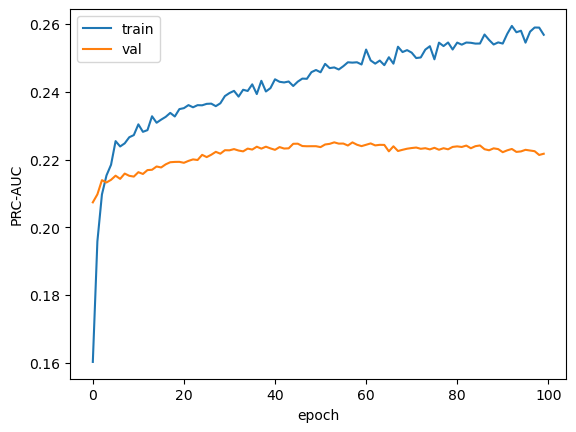

In [59]:
plt.figure()
plt.plot(train_ap_history,label='train')
plt.plot(val_ap_history,label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('PRC-AUC')

Text(0, 0.5, 'loss')

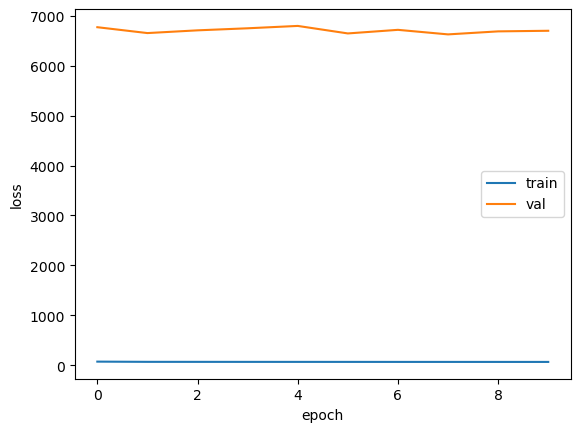

In [102]:
plt.figure()
plt.plot(train_loss_history,label='train')
plt.plot(val_loss_history,label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

In [110]:
def test(model, X, y):
    X = torch.tensor(X,dtype=torch.float32)
    y = torch.tensor(y.values,dtype=torch.int64)
    model.eval()
    with torch.no_grad():
        out = model(X)
        pred_proba = F.softmax(out,dim=1).detach().numpy()
        pred = np.argmax(pred_proba,axis=1)
    
    return pred,pred_proba

yy_pred,yy_pred_proba = test(model, XX_test_processed, yy_test)
ap = average_precision_score(yy_test, yy_pred_proba[:, 1])
roc = roc_auc_score(yy_test, yy_pred_proba[:, 1])
acc = accuracy_score(yy_test, yy_pred)
logloss = log_loss(yy_test, yy_pred_proba[:, 1])
ap,roc,acc,logloss

(0.2154232401439194, 0.741004890189763, 0.6814763627494818, 0.5909212756082874)

### EVALUATION

In [19]:
pipe = Pipeline(steps=[("preprocessor",preprocessor),
                       ("smote",SMOTE(random_state=42)),
                      ('classifier', RandomForestClassifier(random_state=42,n_jobs=-1,
                                                         class_weight='balanced'))])
pipe.set_params(**space_eval(param,result)) 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median'))]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'CNT_FAM_MEMBERS',
                                                   'RE...
                                                   'FLAG_DOCUMENT_11',
                                                   'FLAG_DOCUMENT_12',
                                                   'FLAG_DOCUMENT_13',
                                                   'FLAG_DOCUMENT_14',
                                                   'FLAG_DOCUMENT_15',
                                                   'FLAG_DOCUMENT_16',
                                                   'FLAG_DOCUMENT_17',
                                                   'FLAG_DOCUMENT_18',
                                                   'FLAG_DOCUMENT_19', ...])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(ccp_alpha=98.83414154382557,
                                        class_weight='balanced', max_depth=10,
                                        min_samples_leaf=7, n_jobs=-1,
                                        random_state=42))])

In [260]:
pipe = Pipeline(steps=[#("undersampler", RandomUnderSampler()),
                       ("preprocessor",preprocessor),
                       #("smote",SMOTE(random_state=42)),
                       ('classifier', XGBClassifier(scale_pos_weight=(y_train==0).sum()/(y_train==1).sum()))])
pipe.set_params(**space_eval(param,result))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num1',
                                                  Pipeline(steps=[('pass',
                                                                   'passthrough')]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'CNT_FAM_MEMBERS',
                                                   'REGION_RATING_CLIENT',
                                                   'EXT_SOURCE_2',
                                                   'DAYS...
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               lambda=2.977695707610445, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=3.788857718051868, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [45]:
result = {
  "class_weight": 0,
  "l2_regularization": 8.008941566201596,
  "learning_rate": 0.29305364694969455,
  "max_depth": 4,
  "max_leaf_nodes": 74.57094257536562,
  "min_samples_leaf": 100.68769976033155
}
param = {#'preprocessor__num__imputer__strategy':hp.choice('strategy',['mean','median']),
         'classifier__learning_rate': hp.loguniform('learning_rate',-5,0),
         'classifier__max_depth': scope.int(hp.uniform('max_depth', 2,10)),
         'classifier__min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 10,300,10)),
         'classifier__l2_regularization' : hp.uniform('l2_regularization', 1,10),
         'classifier__max_leaf_nodes':scope.int(hp.quniform('max_leaf_nodes',10,300,10)),
         'classifier__class_weight':hp.choice('class_weight',["balanced"])
}

In [46]:
pipe = Pipeline(steps=[#("undersampler", RandomUnderSampler()),
                       ("preprocessor",preprocessor),
                       #("smote",SMOTE(random_state=42)),
                       ('classifier', HistGradientBoostingClassifier())])
pipe.set_params(**space_eval(param,result))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num1',
                                                  Pipeline(steps=[('pass',
                                                                   'passthrough')]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'CNT_FAM_MEMBERS',
                                                   'REGION_RATING_CLIENT',
                                                   'EXT_SOURCE_2',
                                                   'DAYS...
                                                   'ORGANIZATION_TYPE']),
                                                 ('binary',
                                                  Pipeline(steps=[('pass',
                                                                   'passthrough')]),
                                                  ['FLAG_EMP_PHONE',
                                                   'FLAG_WORK_PHONE',
                                                   'FLAG_CONT_MOBILE',
                                                   'FLAG_PHONE',
                                                   'FLAG_EMAIL'])])),
                ('classifier',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                l2_regularization=8.008941566201596,
                                                learning_rate=0.29305364694969455,
                                                max_depth=4, max_leaf_nodes=74,
                                                min_samples_leaf=100))])

In [111]:
pipe.fit(X_train,y_train)
y_pred_proba = pipe.predict_proba(X_test)
average_precision_score(y_test,y_pred_proba[:,1])

0.2369585582396273

In [141]:
# save model for deployment
import pickle
pickle.dump(pipe, open('loan_histgb.pkl', 'wb'))

In [106]:
precision, recall, thresh = precision_recall_curve(y_test,y_pred_proba[:,1])
auc(recall,precision)

0.2418080909084756

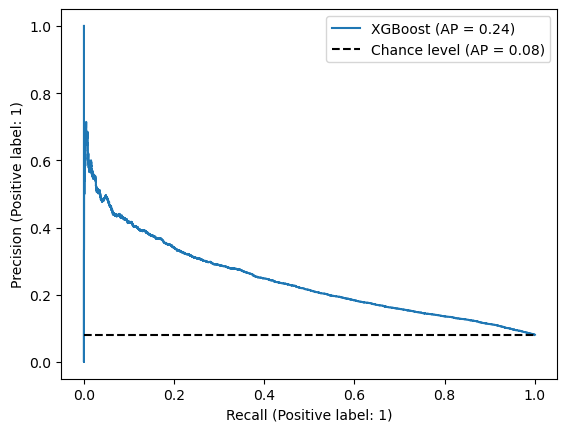

In [107]:
display = PrecisionRecallDisplay.from_predictions(
    y_test, y_pred_proba[:,1], name="XGBoost", plot_chance_level=True
)
plt.legend(loc='upper right')

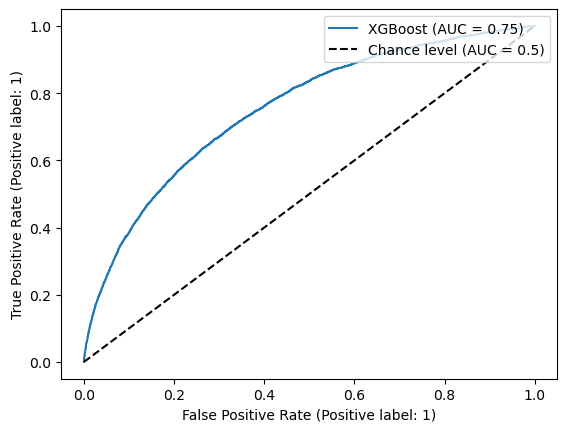

In [108]:
display = RocCurveDisplay.from_predictions(
    y_test, y_pred_proba[:,1], name="XGBoost", plot_chance_level=True
)
plt.legend(loc='upper right')

In [109]:
y_pred = pipe.predict(X_test)
accuracy_score(y_test,y_pred)

0.7003235614522869

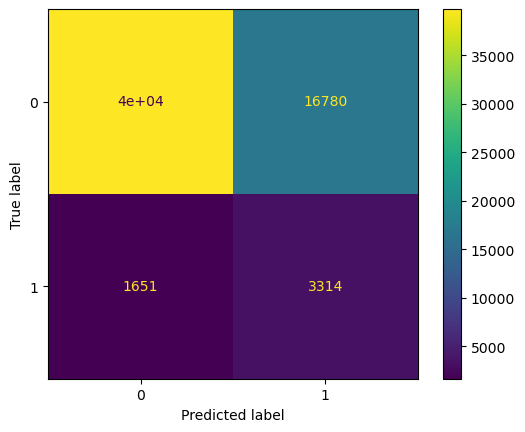

In [110]:
ConfusionMatrixDisplay.from_estimator(pipe,X_test,y_test)

In [122]:
# calculate the optimal threshold by maximizing F1 score from PRC-AUC
f1 = 2*precision*recall/(precision+recall)
best_threshold = thresh[np.nanargmax(f1)]
best_threshold

invalid value encountered in divide


0.6684656596301839

In [123]:
# accuracy with the optimal threshold
accuracy_score(y_test,(y_pred_proba[:,1]>best_threshold).astype(int))

0.851535697445653

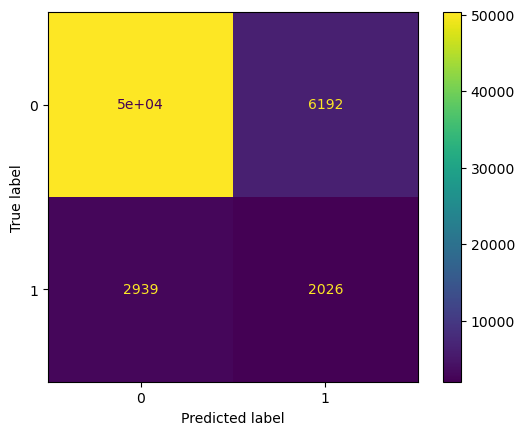

In [124]:
# confusion matrix with the optimal threshold
ConfusionMatrixDisplay.from_predictions(y_test,(y_pred_proba[:,1]>best_threshold).astype(int))

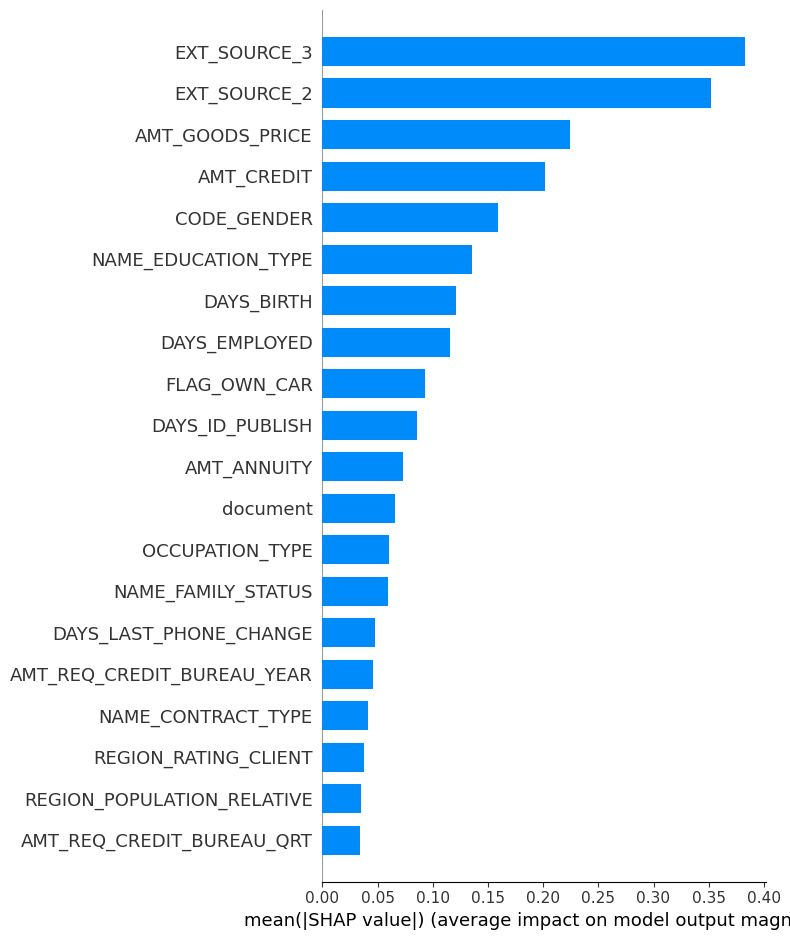

In [31]:
#set the tree explainer as the model of the pipeline
explainer = shap.Explainer(pipe['classifier'])

#apply the preprocessing to X_test
observations = pipe['preprocessor'].transform(X_test)

#get Shap values from preprocessed data
#shap_values = explainer.shap_values(observations.todense())
shap_values = explainer.shap_values(observations)

#plot the feature importance
shap.summary_plot(shap_values, observations, plot_type="bar", feature_names=X_train.columns)

In [140]:
# predict a single test applicant
applicant_index=0
test = X_test.iloc[[applicant_index]]
pipe.predict_proba(test)[:,1][0]

0.3011872149608765

In [143]:
observations = pipe['preprocessor'].transform(X_test)
explainer = shap.Explainer(pipe['classifier'],observations,feature_names=X_test.columns)
sv = explainer(observations,check_additivity=False)

100%|===================| 61214/61503 [01:36<00:00]        

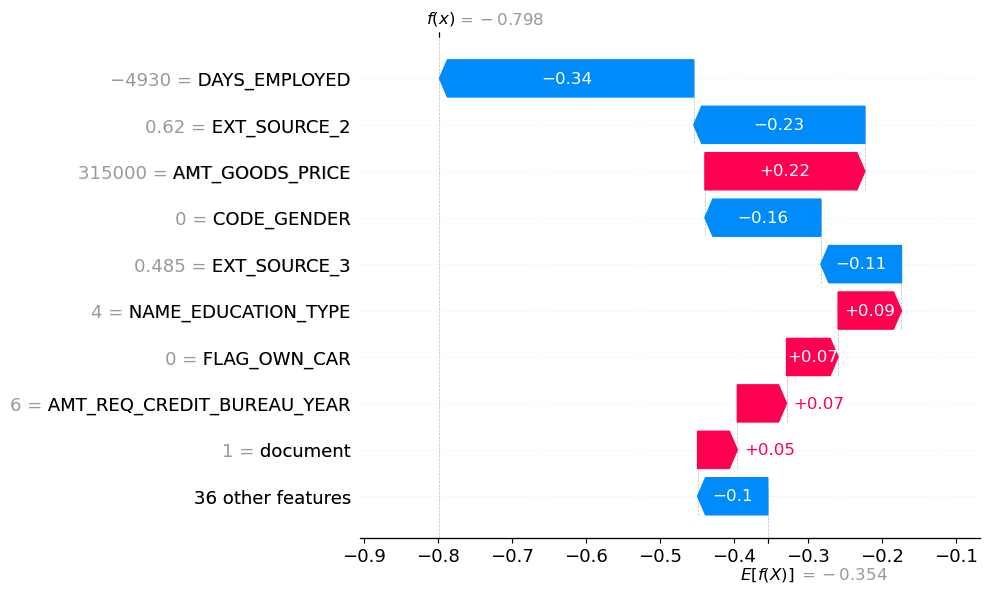

In [145]:
shap.plots.waterfall(sv[1], max_display=10)

LightGBM: histogram-based split finding, leaf-wise tree growth --> more accurate but might overfit, faster and more memory-efficient
HistGradientBoosting: histogram-based split finding, level-wise tree growth
XGBoost: global scan split finding, level-wise tree growth. Use of sparse matrices with sparsity aware algorithms.
Improved data structures for better processor cache utilization which makes it faster. Better support for multicore processing which reduces overall training time.